# Data Merge, Cleaning, EDA, Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Load & Merge Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/train.csv", parse_dates=["Date"])
test = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/test.csv", parse_dates=["Date"])
store = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/store.csv")

print(train.shape)
print(test.shape)


/tmp/ipython-input-3509644983.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/train.csv", parse_dates=["Date"])


(1017209, 9)
(41088, 8)


In [ ]:
assert train.Store.nunique() == store.Store.nunique()

train = train.merge(store, on="Store", how="left")
test = test.merge(store, on="Store", how="left")

print(train.shape)
print(test.shape)

(1017209, 18)
(41088, 17)


In [ ]:
# Duplicate Check (After Merge)

print("Train duplicate rows:", train.duplicated().sum())
print("Test duplicate rows:", test.duplicated().sum())


Train duplicate rows: 0
Test duplicate rows: 0


### Data Quality Checks

In [ ]:
def missing_report(df):
    return (df.isna().sum()/len(df)).sort_values(ascending=False)

missing_report(train).head(10)


,0
Promo2SinceWeek,0.499436
PromoInterval,0.499436
Promo2SinceYear,0.499436
CompetitionOpenSinceYear,0.317878
CompetitionOpenSinceMonth,0.317878
CompetitionDistance,0.002597
DayOfWeek,0.000000
Store,0.000000
Date,0.000000
Sales,0.000000


### Data Cleaning

In [ ]:
# Remove closed stores with sales
train = train[~((train["Open"] == 0) & (train["Sales"] > 0))]
train = train[train["Open"] == 1]


In [ ]:
# Missing values report
missing = train.isna().mean().sort_values(ascending=False)
missing.head(10)


,0
Promo2SinceWeek,0.501316
PromoInterval,0.501316
Promo2SinceYear,0.501316
CompetitionOpenSinceYear,0.318121
CompetitionOpenSinceMonth,0.318121
CompetitionDistance,0.002589
DayOfWeek,0.000000
Store,0.000000
Date,0.000000
Sales,0.000000


## EDA

In [ ]:
train.info()
train.describe()
train.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64     

,0
Promo2SinceWeek,423307
PromoInterval,423307
Promo2SinceYear,423307
CompetitionOpenSinceYear,268619
CompetitionOpenSinceMonth,268619
CompetitionDistance,2186
DayOfWeek,0
Store,0
Date,0
Sales,0


### UNIVARIATE ANALYSIS

### Numerical

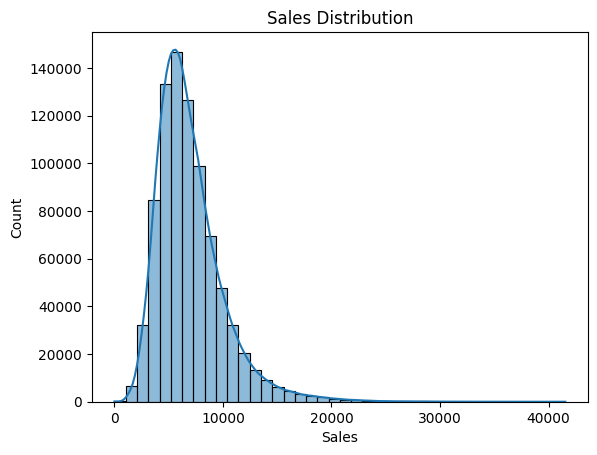

In [ ]:
sns.histplot(train["Sales"], bins=40, kde=True)
plt.title("Sales Distribution")
plt.show()

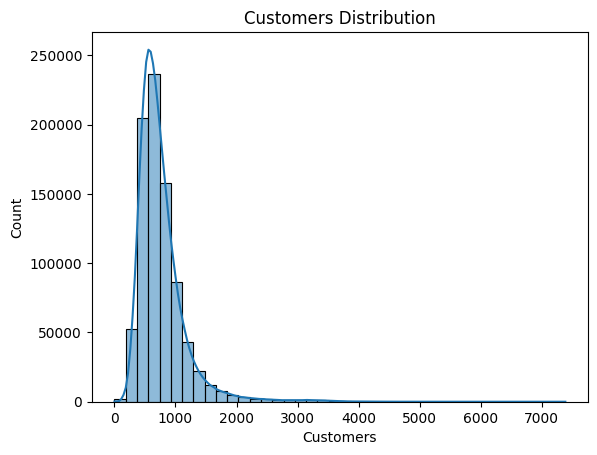

In [ ]:
sns.histplot(train["Customers"], bins=40, kde=True)
plt.title("Customers Distribution")
plt.show()


### Categorical

In [ ]:
print(train["StoreType"].isna().sum())
print(train["StoreType"].unique())
print(train.columns)



0
['c' 'a' 'd' 'b']
Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


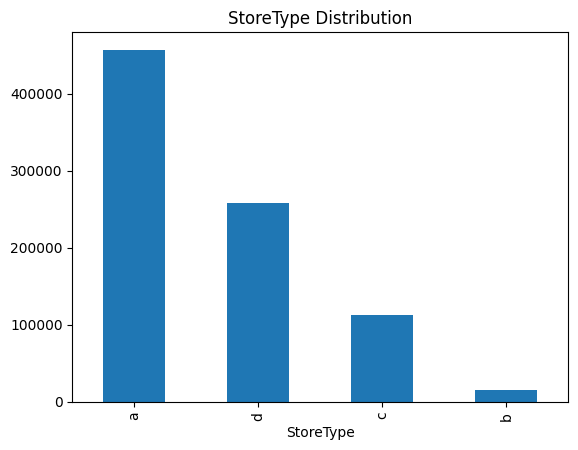

In [ ]:
train["StoreType"].value_counts().plot(kind="bar", title="StoreType Distribution")
plt.show()


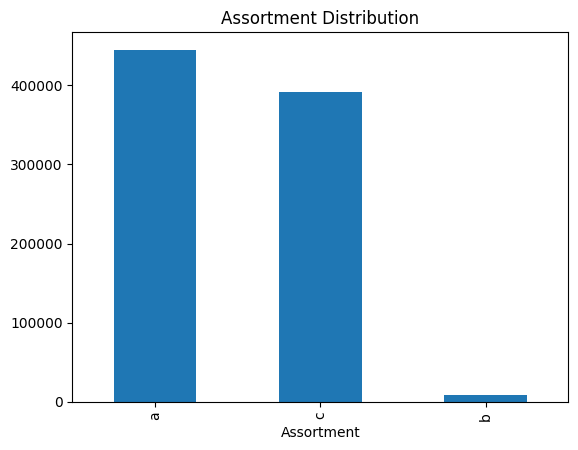

In [ ]:
train["Assortment"].value_counts().plot(kind="bar", title="Assortment Distribution")
plt.show()


### BIVARIATE ANALYSIS

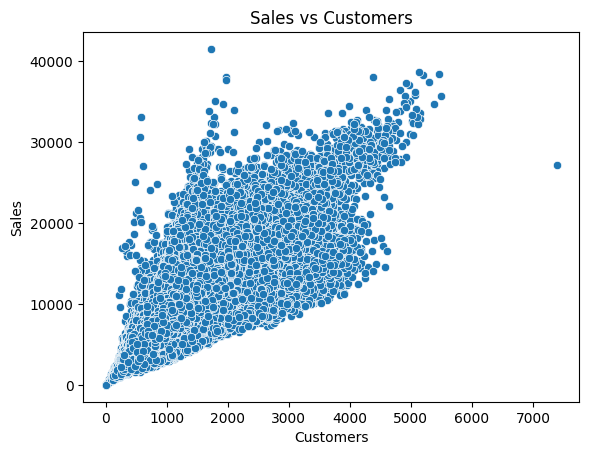

In [ ]:
# Sales vs Customers
sns.scatterplot(data=train, x="Customers", y="Sales")
plt.title("Sales vs Customers")
plt.show()


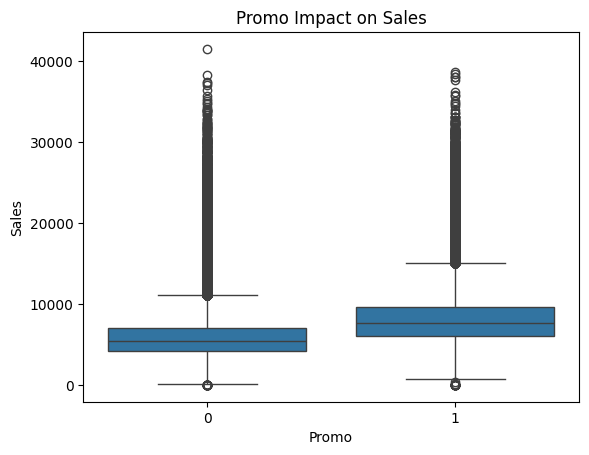

In [ ]:
# Promo Impact
sns.boxplot(data=train, x="Promo", y="Sales")
plt.title("Promo Impact on Sales")
plt.show()


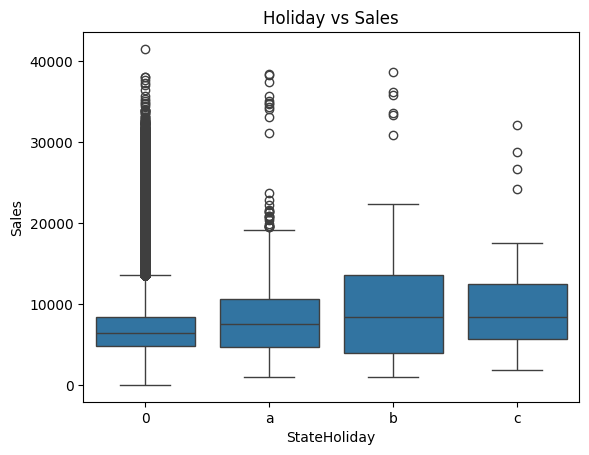

In [ ]:
# Holiday Effect
sns.boxplot(data=train, x="StateHoliday", y="Sales")
plt.title("Holiday vs Sales")
plt.show()

### MULTIVARIATE ANALYSIS

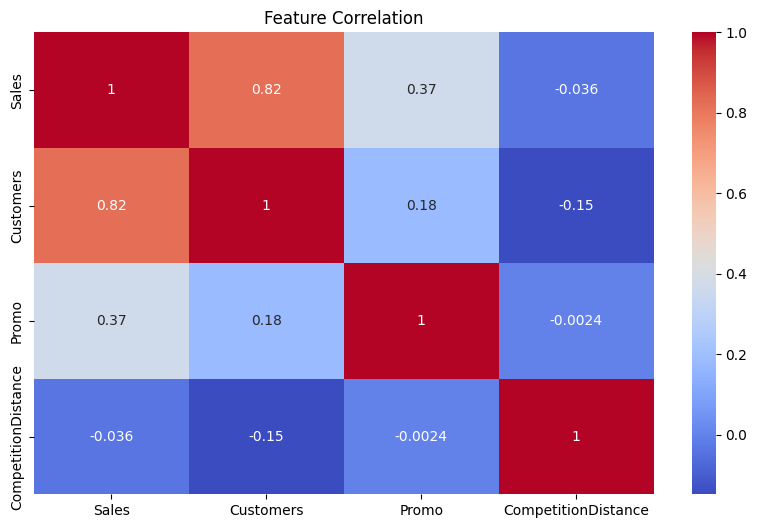

In [ ]:
# Correlation
plt.figure(figsize=(10,6))
sns.heatmap(
    train[["Sales","Customers","Promo","CompetitionDistance"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Feature Correlation")
plt.show()


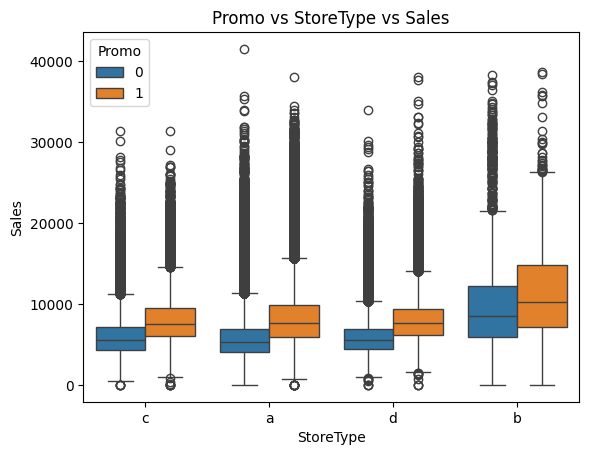

In [ ]:
# Promo with StoreType
sns.boxplot(data=train, x="StoreType", y="Sales", hue="Promo")
plt.title("Promo vs StoreType vs Sales")
plt.show()


### Feature Engineering (Date-Based)

In [ ]:
train["Date"] = pd.to_datetime(train["Date"])
test["Date"]  = pd.to_datetime(test["Date"])


In [ ]:
# Core Time-Based Features
for df in [train, test]:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.weekday
    df["IsWeekend"] = df["Weekday"].isin([5, 6]).astype(int)

In [ ]:
# Beginning / Mid / End of Month
for df in [train, test]:
    df["MonthPart"] = pd.cut(
        df["Day"],
        bins=[0, 10, 20, 31],
        labels=["Start", "Mid", "End"]
    )

In [ ]:
# Holiday Features
# StateHoliday
holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3}

for df in [train, test]:
    df["StateHoliday"] = df["StateHoliday"].map(holiday_map)

# Holiday Indicator
for df in [train, test]:
    df["IsHoliday"] = (df["StateHoliday"] > 0).astype(int)

In [ ]:
# Days Before & After Holiday
for df in [train, test]:
    df["DaysBeforeHoliday"] = (
        df.groupby("Store")["IsHoliday"].shift(-1).fillna(0)
    )

    df["DaysAfterHoliday"] = (
        df.groupby("Store")["IsHoliday"].shift(1).fillna(0)
    )

In [ ]:
# Promotion Features
for df in [train, test]:
    df["Promo"] = df["Promo"].astype(int)
    df["Promo2"] = df["Promo2"].fillna(0).astype(int)

In [ ]:
# Competition Features
for df in [train, test]:
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(
        df["CompetitionDistance"].median()
    )
for df in [train, test]:
    df["CompetitionOpenMonths"] = (
        (df["Year"] - df["CompetitionOpenSinceYear"]) * 12 +
        (df["Month"] - df["CompetitionOpenSinceMonth"])
    )

    df["CompetitionOpenMonths"] = (
        df["CompetitionOpenMonths"].fillna(0).clip(lower=0)
    )

In [ ]:
train.isnull().sum().sort_values(ascending=False).head()
train.shape
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'Weekday',
       'IsWeekend', 'MonthPart', 'IsHoliday', 'DaysBeforeHoliday',
       'DaysAfterHoliday', 'CompetitionOpenMonths'],
      dtype='object')

In [ ]:
train.to_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/processed_train.csv", index=False)
test.to_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/processed_test.csv", index=False)
